In [ ]:
# import relevant libraries

import pandas as pd
import numpy as np
import cv2
import os
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import random
from google.colab import drive

In [ ]:
# import the dataset from the google drive

drive.mount('/content/drive')

flowers = !unzip '/content/drive/MyDrive/Flowers and Objects Dataset/Flowers.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create an instance of SIFT class to be used as a feature descriptor

sift = cv2.xfeatures2d.SIFT_create()

In [ ]:
# create an instance of svm and random forest objects

svm = SVC()
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)

In [ ]:
# create an instance of the encoders

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

## Flowers DataSet

In [ ]:
# extract the feature descriptors using sift for each image 
# append all the feature descriptors and then vertically stack them

flowers_path = '/content/flower_photos'
features = []

for i in os.listdir(flowers_path):
  for im in os.listdir(flowers_path+'/'+i):
    img = cv2.imread(flowers_path+'/'+i+'/'+im)
    kp, img_des = sift.detectAndCompute(img, None)
    features.append(img_des)
features = np.vstack(features)

In [ ]:
# apply kmeans algorithm to the features to build the vocabulary which is merely the centres of each cluster
# k=100 is used as it gave the best performance on this data set
# n_init=3 is due to time needed, it can be increased for better performance

kmeans = KMeans(n_clusters = 100, n_init=3)
kmeans.fit(features)
flowers_visual_words = kmeans.cluster_centers_ 

In [ ]:
# represent each image as a histogram 
  # each feature descriptor of the image is represented as the closest visual word existing in the vocabulary
  # the histogram contains the count of each of the visual word in one image
# labels of each train image is also appended in a list

flowers_labels = []
flowers_hist = []

for i in os.listdir(flowers_path):
  for im in os.listdir(flowers_path+'/'+i):
    img = cv2.imread(flowers_path+'/'+i+'/'+im)
    kp, img_des = sift.detectAndCompute(img, None)
    histogram = np.zeros(len(flowers_visual_words))
    for d in img_des:
      distances = np.linalg.norm(flowers_visual_words - d, axis=1)
      nearest_visual_word = np.argmin(distances)
      histogram[nearest_visual_word] += 1
    flowers_hist.append(histogram)
    flowers_labels.append(i)
flowers_hist = np.vstack(flowers_hist)

In [ ]:
# split the dataset into train and test 

flowers_train_hist, flowers_test_hist, flowers_train_labels, flowers_test_labels =  train_test_split(flowers_hist, flowers_labels, test_size=0.2)

### SVM

In [ ]:
# transform the labels

label_encoder = LabelEncoder()

integer_encoded = label_encoder.fit_transform(flowers_train_labels)
flowers_train_labels = integer_encoded.reshape(len(integer_encoded), 1)

integer_encoded = label_encoder.fit_transform(flowers_test_labels)
flowers_test_labels = integer_encoded.reshape(len(integer_encoded), 1)

In [ ]:
# fit the svm classifier for the flowers data set

flowers_svm = svm.fit(flowers_train_hist, flowers_train_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# make predictions on the test set

flowers_svm_pred = flowers_svm.predict(flowers_test_hist)

In [ ]:
# accuracy score, f1-score, TPR and FPR

flr_svm_acc = accuracy_score(flowers_test_labels, flowers_svm_pred)*100
flr_svm_f1 = f1_score(flowers_test_labels, flowers_svm_pred, average='macro')*100
cnf_matrix = confusion_matrix(flowers_test_labels, flowers_svm_pred)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
flr_svm_TPR = np.mean(TP/(TP+FN))*100
flr_svm_FPR = np.mean(FP/(FP+TN))*100

print('\nSVM on Flowers Dataset\n')
print('Accuracy: ',flr_svm_acc,'%\nF1-Score: ',flr_svm_f1,'%\nTrue Positive Rate: ',flr_svm_TPR,'%\nFalse Positive Rate: ',flr_svm_FPR,'%')


SVM on Flowers Dataset

Accuracy:  59.12806539509536 %
F1-Score:  57.38851625823903 %
True Positive Rate:  57.109439820658345 %
False Positive Rate:  10.365193099956132 %


Run the classifier on few randomly images to show some correct and incorrect classifications

***Note:*** There might be a need to run the below 2 cells multiple times as there might be a chance that the randomly selected contains none of the incorreclty classified images


In [ ]:
selected_fl_svm_images = []
selected_fl_svm_hist = []
selected_fl_svm_labels = []

# randomly select 3 images from each class
for i in os.listdir(flowers_path):
  imgs = random.sample(os.listdir(flowers_path+'/'+i), 3)
  for im in imgs:
    selected_fl_svm_images.append(flowers_path+'/'+i+'/'+str(im))
    selected_fl_svm_labels.append(i)

# transform the labels
integer_encoded = label_encoder.fit_transform(selected_fl_svm_labels)
selected_fl_svm_labels = integer_encoded.reshape(len(integer_encoded), 1)

# find the histograms for each image
for i in range(len(selected_fl_svm_images)):
  img = cv2.imread(selected_fl_svm_images[i])
  kp, img_des = sift.detectAndCompute(img, None)
  histogram = np.zeros(len(flowers_visual_words))
  for d in img_des:
    distances = np.linalg.norm(flowers_visual_words - d, axis=1)
    nearest_visual_word = np.argmin(distances)
    histogram[nearest_visual_word] += 1
  selected_fl_svm_hist.append(histogram)
selected_fl_svm_hist = np.vstack(selected_fl_svm_hist)

# make predictions
selected_fl_svm_pred = flowers_svm.predict(selected_fl_svm_hist)

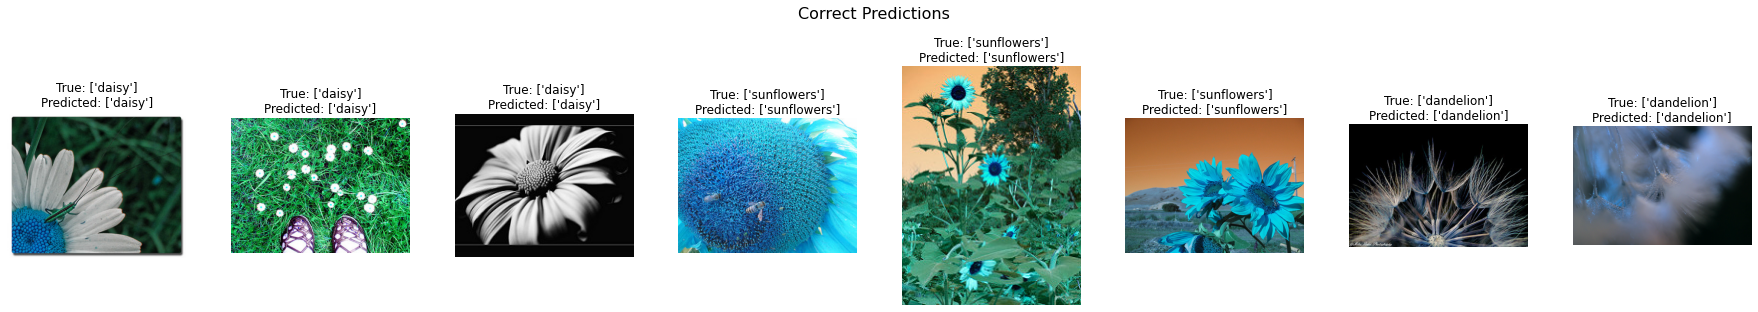

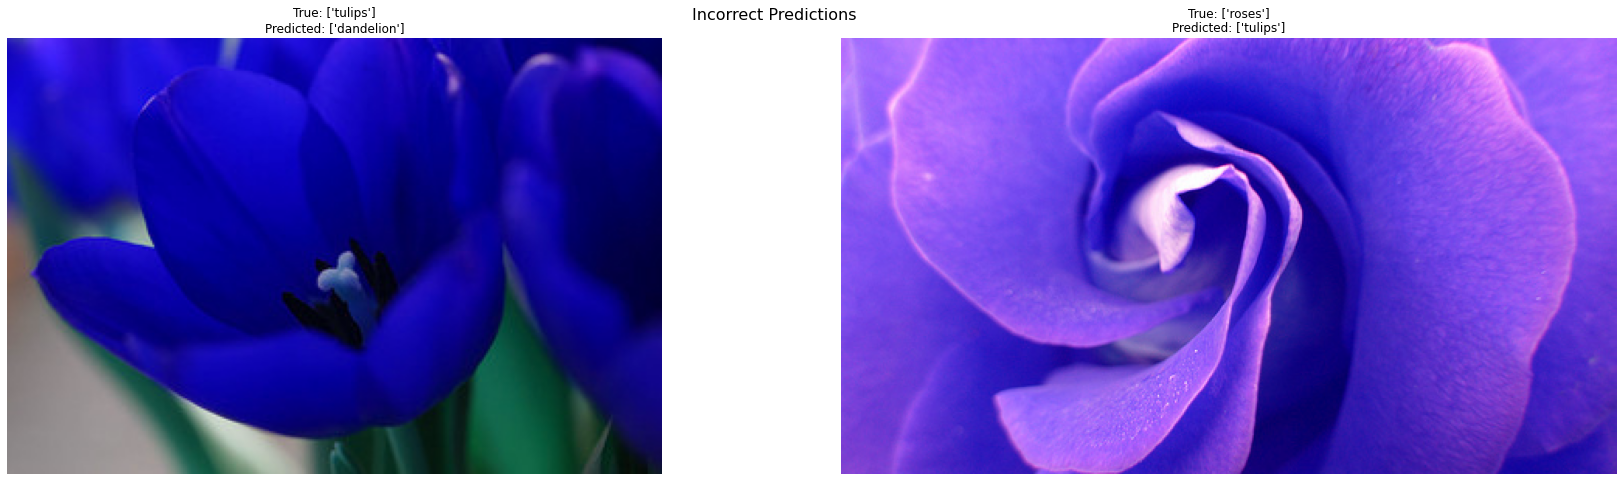

In [ ]:
# plot the images along with the true and predicted labels with a maximum of 8 correctly classified being shown

cor, incor = 0,0
true, false = 0,0
for i in range(len(selected_fl_svm_images)):
    if selected_fl_svm_labels[i]==selected_fl_svm_pred[i]:
      true+=1
    else:
      false+=1

fig1, axes1 = plt.subplots(1, true if true<=8 else 8, figsize=(25, 5))
fig1.suptitle('Correct Predictions', fontsize=16)
fig1.tight_layout()
fig2, axes2 = plt.subplots(1, false, figsize=(25, 7))
fig2.suptitle('Incorrect Predictions', fontsize=16)
fig2.tight_layout()
for i in range(len(selected_fl_svm_images)):
    img = cv2.imread(selected_fl_svm_images[i])
    if selected_fl_svm_labels[i]==selected_fl_svm_pred[i]  and cor<8:
      axes1[cor].imshow(img)
      axes1[cor].set_title(f"True: {label_encoder.inverse_transform(selected_fl_svm_labels[i])}\nPredicted: {label_encoder.inverse_transform([selected_fl_svm_pred[i]])}")
      axes1[cor].axis('off')
      cor+=1
    elif selected_fl_svm_labels[i]!=selected_fl_svm_pred[i]:
      axes2[incor].imshow(img)
      axes2[incor].set_title(f"True: {label_encoder.inverse_transform(selected_fl_svm_labels[i])}\nPredicted: {label_encoder.inverse_transform([selected_fl_svm_pred[i]])}")
      axes2[incor].axis('off')
      incor+=1

plt.show()

### RF

In [ ]:
# transform the labels into one hot encodings

flowers_train_rf_labels = onehot_encoder.fit_transform(flowers_train_labels)
flowers_test_rf_labels = onehot_encoder.fit_transform(flowers_test_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# train the classifier

flowers_rf = rf.fit(flowers_train_hist, flowers_train_rf_labels)

In [ ]:
# make predictions on the test set

flowers_rf_pred = flowers_rf.predict(flowers_test_hist)

In [ ]:
# transform the predictions from probabilities

for i in flowers_rf_pred:
  m=max(i)
  for el in range(len(i)):
    if i[el]==m:
      i[el]=1.0
    else:
      i[el]=0.0

In [ ]:
# accuracy score, f1-score, TPR and FPR

fl_rf_acc = accuracy_score(flowers_test_rf_labels, flowers_rf_pred)*100
fl_rf_f1 = f1_score(flowers_test_rf_labels, flowers_rf_pred, average='macro')*100
cnf_matrix = confusion_matrix(flowers_test_rf_labels.argmax(axis=1), flowers_rf_pred.argmax(axis=1))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
fl_rf_TPR = np.mean(TP/(TP+FN))*100
fl_rf_FPR = np.mean(FP/(FP+TN))*100

print('\nRandom Forest on Flowers Dataset\n')
print('Accuracy: ',fl_rf_acc,'%\nF1-Score: ',fl_rf_f1,'%\nTrue Positive Rate: ',fl_rf_TPR,'%\nFalse Positive Rate: ',fl_rf_FPR,'%')


Random Forest on Flowers Dataset

Accuracy:  56.13079019073569 %
F1-Score:  53.79247202268568 %
True Positive Rate:  53.953072384880116 %
False Positive Rate:  11.077186538873969 %


Run the classifier on few randomly images to show some correct and incorrect classifications

***Note:*** There might be a need to run the below 2 cells multiple times as there might be a chance that the randomly selected contains none of the incorreclty classified images


In [ ]:
selected_fl_rf_images = []
selected_fl_rf_hist = []
selected_fl_rf_labels = []

# randomly select 3 images from each class
for i in os.listdir(flowers_path):
  imgs = random.sample(os.listdir(flowers_path+'/'+i), 3)
  for im in imgs:
    selected_fl_rf_images.append(flowers_path+'/'+i+'/'+str(im))
    selected_fl_rf_labels.append(i)

# transform the labels
integer_encoded = label_encoder.fit_transform(selected_fl_rf_labels)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
selected_fl_rf_labels = onehot_encoder.fit_transform(integer_encoded)

# make histograms for the images
for i in range(len(selected_fl_rf_images)):
  img = cv2.imread(selected_fl_rf_images[i])
  kp, img_des = sift.detectAndCompute(img, None)
  histogram = np.zeros(len(flowers_visual_words))
  for d in img_des:
    distances = np.linalg.norm(flowers_visual_words - d, axis=1)
    nearest_visual_word = np.argmin(distances)
    histogram[nearest_visual_word] += 1
  selected_fl_rf_hist.append(histogram)
selected_fl_rf_hist = np.vstack(selected_fl_rf_hist)

# make predictions for the images
selected_fl_rf_pred = flowers_rf.predict(selected_fl_rf_hist)
for i in selected_fl_rf_pred:
  m=max(i)
  for el in range(len(i)):
    if i[el]==m:
      i[el]=1.0
    else:
      i[el]=0.0

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


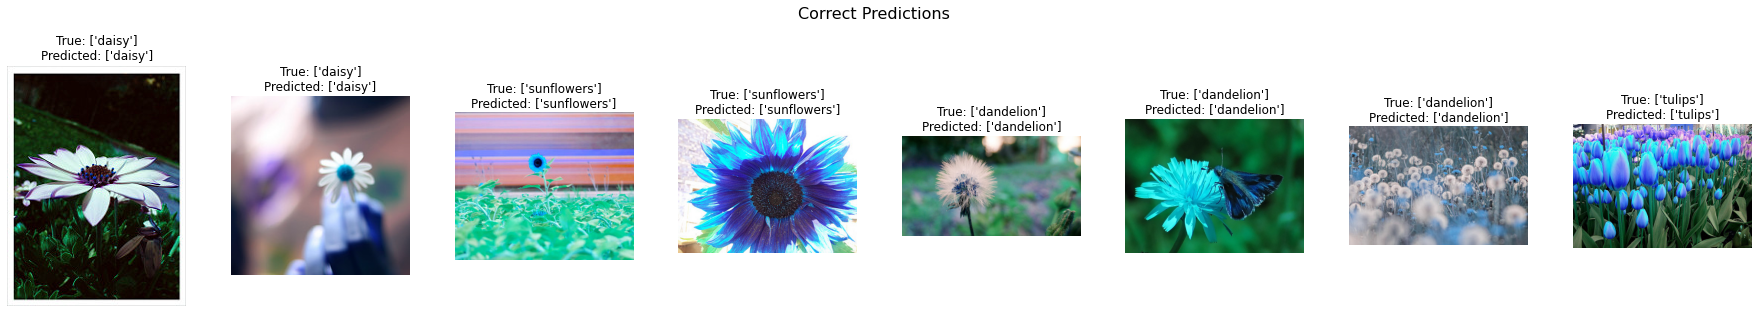

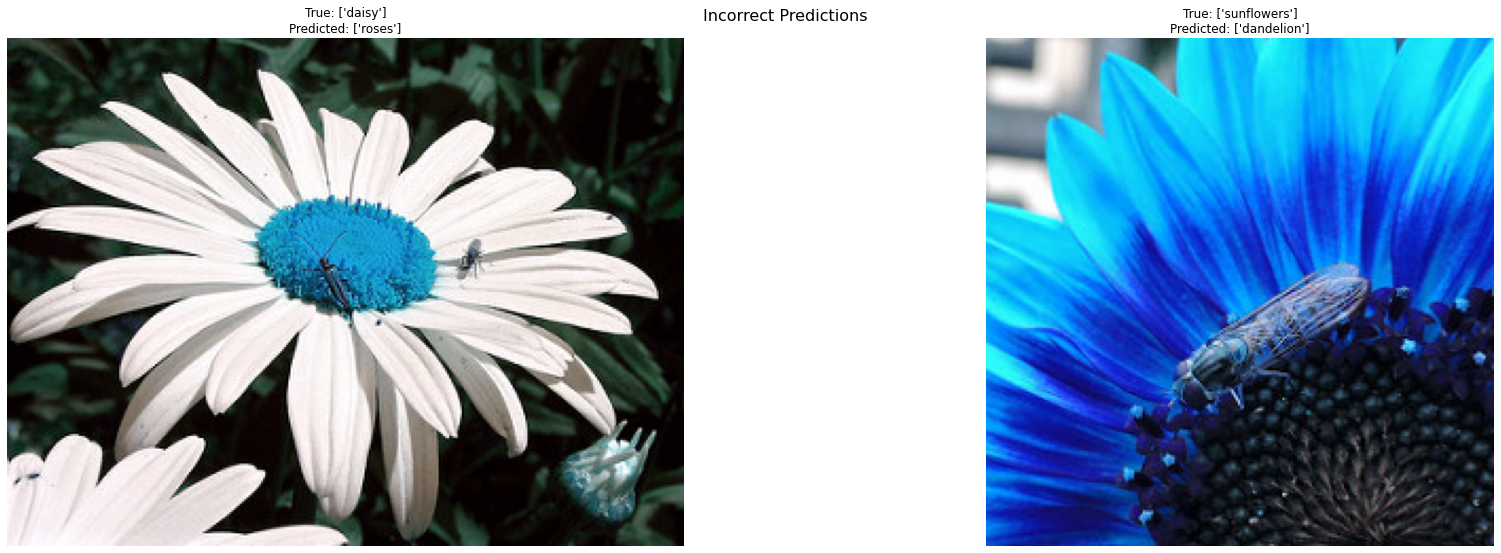

In [ ]:
# plot the selected images with their true and predicted labels
# a maximum of 8 correctly classified images are shown

cor, incor = 0,0
true, false = 0,0
for i in range(len(selected_fl_rf_images)):
    if selected_fl_rf_labels[i].argmax()==selected_fl_rf_pred[i].argmax():
      true+=1
    else:
      false+=1

fig1, axes1 = plt.subplots(1, true if true<=8 else 8, figsize=(25, 5))
fig1.suptitle('Correct Predictions', fontsize=16)
fig1.tight_layout()
fig2, axes2 = plt.subplots(1, false, figsize=(25,8))
fig2.suptitle('Incorrect Predictions', fontsize=16)
fig2.tight_layout()
for i in range(len(selected_fl_rf_images)):
    img = cv2.imread(selected_fl_rf_images[i])
    if selected_fl_rf_labels[i].argmax()==selected_fl_rf_pred[i].argmax() and cor<8:
      axes1[cor].imshow(img)
      axes1[cor].set_title(f"True: {label_encoder.inverse_transform([selected_fl_rf_labels[i].argmax()])}\nPredicted: {label_encoder.inverse_transform([selected_fl_rf_pred[i].argmax()])}")
      axes1[cor].axis('off')
      cor+=1
    elif selected_fl_rf_labels[i].argmax()!=selected_fl_rf_pred[i].argmax():
      axes2[incor].imshow(img)
      axes2[incor].set_title(f"True: {label_encoder.inverse_transform([selected_fl_rf_labels[i].argmax()])}\nPredicted: {label_encoder.inverse_transform([selected_fl_rf_pred[i].argmax()])}")
      axes2[incor].axis('off')
      incor+=1
plt.show()